In [ ]:
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import re
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
!rm -rf 'ml'   
!git clone -q https://github.com/Ardisat/ml.git   

from ml.general.progress_bar import ProgressBar

In [ ]:
original_dataset_path = "/content/drive/MyDrive/MachineLearning/Datasets/LISATrafficLightDataset.zip"
processed_dataset_path = "/content/drive/MyDrive/MachineLearning/TrafficLight/traffic_light_dataset.zip"

In [ ]:
!rm -rf '/dataset'

!mkdir "/dataset"
!mkdir "/dataset/train"
!mkdir "/dataset/val"

!mkdir "/dataset/train/images"
!mkdir "/dataset/train/labels"
!mkdir "/dataset/val/images"
!mkdir "/dataset/val/labels"

In [ ]:
!rm -rf '/original_dataset'
!mkdir '/original_dataset'

In [ ]:
!unzip -q {original_dataset_path} -d '/content/original_dataset'

In [ ]:
target_classes = ['go', 'stop', 'warning']

colors = {
    'go':      'green', 
    'stop':    'red', 
    'warning': 'yellow'
}
# Нуммерация классов необходима для YOLO структуры
ohe = {
    'go':      1, 
    'stop':    2, 
    'warning': 3
}

train_folder_list = [
    'dayTrain',
    'daySequence1',
    'daySequence2',
    'sample-dayClip6',
    'nightTrain',
    'nightSequence1',
    'nightSequence2',
    'sample-nightClip1',
]

In [ ]:
def get_annotarion_dataframe(train_data_folders):
    data_base_path = '/content/original_dataset/'
    annotation_list = list()
    for folder in [folder + '/' for folder in train_data_folders if os.listdir(data_base_path)]:
        annotation_path = ''
        if 'sample' not in folder:
            annotation_path = data_base_path + 'Annotations/Annotations/' + folder
        else:
            annotation_path = data_base_path + folder*2
        image_frame_path = data_base_path + folder*2
        
        df = pd.DataFrame()
        if 'Clip' in os.listdir(annotation_path)[0]:
            clip_list = os.listdir(annotation_path)
            for clip_folder in clip_list:
                df = pd.read_csv(annotation_path + clip_folder +  '/frameAnnotationsBOX.csv', sep=";")
                df['image_path'] = image_frame_path + clip_folder + '/frames/'
                annotation_list.append(df)
        else:
            df = pd.read_csv(annotation_path +  'frameAnnotationsBOX.csv', sep=";")
            df['image_path'] = image_frame_path + 'frames/'
            annotation_list.append(df)
        
    df = pd.concat(annotation_list)
    df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
    df.columns = ['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path']
    df = df[df['target'].isin(target_classes)]
    df['filename'] = df['filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df = df.drop_duplicates().reset_index(drop=True)
    df['path'] = df['image_path'] + df['filename']
    df = df.drop(['image_path', 'filename'], axis=1)
    df['color'] = df['target'].apply(lambda target: colors[target])
    df['target'] = df['target'].apply(lambda target: ohe[target])
    df = df[['color', 'target', 'x1', 'y1', 'x2', 'y2', 'path']]
    return df

In [ ]:
train_annotation_df = get_annotarion_dataframe(train_folder_list).sort_values(by='path')
unique_paths = train_annotation_df['path'].unique().tolist()
unique = {path: i for i, path in enumerate(unique_paths)}

In [ ]:
train_annotation_df

,color,target,x1,y1,x2,y2,path
29698,red,2,706,478,718,500,/content/original_dataset/daySequence1/daySequ...
29699,red,2,705,475,720,497,/content/original_dataset/daySequence1/daySequ...
29700,red,2,707,476,719,494,/content/original_dataset/daySequence1/daySequ...
29701,red,2,708,474,720,492,/content/original_dataset/daySequence1/daySequ...
29702,red,2,707,470,722,492,/content/original_dataset/daySequence1/daySequ...
...,...,...,...,...,...,...,...
96270,green,1,872,17,958,143,/content/original_dataset/sample-nightClip1/sa...
96271,green,1,938,5,1028,131,/content/original_dataset/sample-nightClip1/sa...
96272,green,1,1006,6,1094,117,/content/original_dataset/sample-nightClip1/sa...
96273,green,1,1081,0,1171,110,/content/original_dataset/sample-nightClip1/sa...


In [ ]:
index, counts = np.unique(train_annotation_df['color'], return_counts=True)
train_annotation_df['color'].value_counts()

green     48876
red       44730
yellow     2669
Name: color, dtype: int64

In [ ]:
def box_percentage(box, size):
    x1 = box[0] / size[0]
    y1 = box[1] / size[1]
    x2 = box[2] / size[0]
    y2 = box[3] / size[1]

    return [x1, y1, x2, y2]

In [ ]:
target_size = 800, 800

In [ ]:
!rm -rf "dataset"
!mkdir "dataset"

!rm -rf "dataset/x"
!mkdir "dataset/x"

!rm -rf "dataset/y"
!mkdir "dataset/y"

In [ ]:
folder = "dataset"
pb = ProgressBar(len(train_annotation_df))

for i, (index, row) in enumerate(train_annotation_df.iterrows()):

    label = row['color']
    target = row['target']
    box = row['x1'], row['y1'], row['x2'], row['y2']

    path = row['path']
    path_id = unique[path]

    image = Image.open(path)
    image_resized = image.resize(target_size)

    box_p = box_percentage(box, image.size)
    y = f"{target} " + " ".join([str(b) for b in box_p])

    x_path = f"{folder}/x/{path_id}.jpg"
    y_path = f"{folder}/y/{path_id}.txt"

    if not os.path.exists(x_path):
        image_resized.save(x_path)
        with open(y_path, "w") as f:
            f.write(y)
    else:
        with open(y_path, "a") as f: 
            f.write('\n' + y)

    pb.next()

96275/96275 [==============================] 100%


In [ ]:
!zip -q "/content/drive/MyDrive/MachineLearning/Datasets/traffic_lights.zip" -r "dataset"

In [ ]:
from sklearn.utils import shuffle

In [ ]:
x_paths = os.listdir('/content/dataset/x')
y_paths = os.listdir('/content/dataset/y')

In [ ]:
x_paths, y_paths = shuffle(x_paths, y_paths)

In [ ]:
len(x_paths), len(y_paths)

(36534, 36534)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_paths, y_paths, test_size=0.2)

In [ ]:
print(len(x_train))
print(len(y_train))
print()
print(len(x_val))
print(len(y_val))

29227
29227

7307
7307


TODO: На самом деле папка должна называться val, а не valid
Лучше поправить это руками в уже сформированном датасете для обучения YOLO

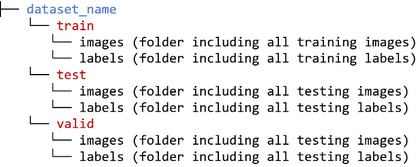

In [ ]:
!rm -rf "traffic_light"
!mkdir "traffic_light"

!rm -rf "traffic_light/train"
!mkdir "traffic_light/train"

!rm -rf "traffic_light/valid"
!mkdir "traffic_light/valid"

!rm -rf "traffic_light/train/images"
!mkdir "traffic_light/train/images"

!rm -rf "traffic_light/train/labels"
!mkdir "traffic_light/train/labels"

!rm -rf "traffic_light/valid/images"
!mkdir "traffic_light/valid/images"

!rm -rf "traffic_light/valid/labels"
!mkdir "traffic_light/valid/labels"

In [ ]:
import shutil

In [ ]:
x_train

In [ ]:
for filename in x_train:
    shutil.move(f'/content/dataset/x/{filename}', f'/content/traffic_light/train/images/{filename}')
for filename in y_train:
    shutil.move(f'/content/dataset/y/{filename}', f'/content/traffic_light/train/labels/{filename}')
for filename in x_val:
    shutil.move(f'/content/dataset/x/{filename}', f'/content/traffic_light/valid/images/{filename}')
for filename in y_val:
    shutil.move(f'/content/dataset/y/{filename}', f'/content/traffic_light/valid/labels/{filename}')

In [ ]:
print(len(os.listdir("traffic_light/train/images/")))
print(len(os.listdir("traffic_light/train/labels/")))
print(len(os.listdir("traffic_light/valid/images/")))
print(len(os.listdir("traffic_light/valid/labels/")))

29227
29227
7307
7307


Также в датасет-архив нужно добавить конфигурационные файлы под YOLO

In [ ]:
!zip -q "/content/drive/MyDrive/MachineLearning/Datasets/traffic_light.zip" -r "traffic_light"

## Test

---



In [ ]:
from PIL import Image, ImageDraw

In [ ]:
i = 500

image = Image.open(f"/content/traffic_light/train/images/{i}.jpg")
bboxes = open(f"/content/traffic_light/train/labels/{i}.txt").read().splitlines()

In [ ]:
bbox = [bbox[2:].split(' ') for bbox in bboxes]

In [ ]:
bbox

[['0.34296875', '0.45729166666666665', '0.3546875', '0.48541666666666666'],
 ['0.49375', '0.41458333333333336', '0.503125', '0.43333333333333335'],
 ['0.5828125', '0.459375', '0.596875', '0.4875']]

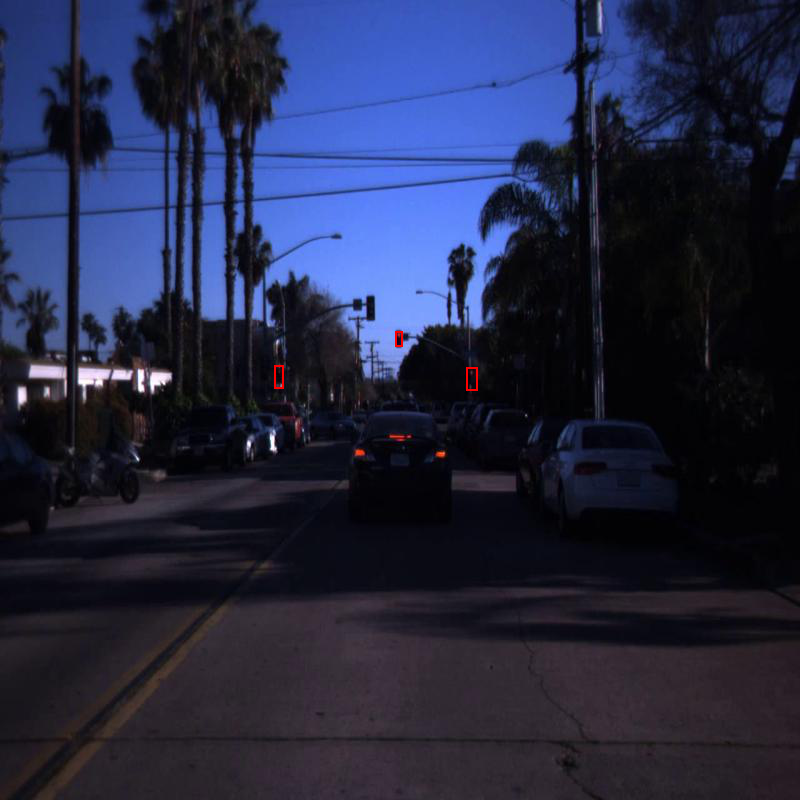

In [ ]:
draw = ImageDraw.Draw(image)

for x1, y1, x2, y2 in bbox:
    x1, y1, x2, y2 = float(x1)*image.size[0], float(y1)*image.size[1], float(x2)*image.size[0], float(y2)*image.size[1]
    draw = ImageDraw.Draw(image)
    draw.rectangle((x1, y1, x2, y2), outline="red", width=2)

image.show()